In [1]:
import sys
sys.path.insert(1, '/Users/jeanettemumford/Dropbox/Research/Projects/RT_sims/Code')
from functions import *
import seaborn as sns
import pandas as pd
from scipy import signal
from scipy.stats import exponnorm, gamma
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')



/Users/jeanettemumford/.pyenv/versions/3.8.5/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


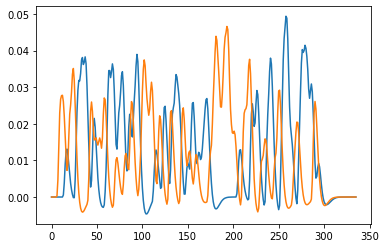

336


In [5]:
nsub = 30
n_trials = 80
scan_length = 350
repetition_time = 1
mu_grinband_shift = 638
inv_lambda_grinband_shift = 699
sigma_grinband_shift = 103
mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift
#Stroop settings
#mu_expnorm = 530
#lam_expnorm = 1 / 160
#sigma_expnorm = 77
max_rt = 8000
min_rt = 50
event_duration = .1  
center_rt=False
hp_filter = True
ISI_min = 1
ISI_max = 3
nsim_sd_est = 100
nsim_power = 1000

rt_diff_s = .3
beta_scales_yes = np.array([.75, 1.1])
beta_scales_no = np.array([.85, 1.3])
win_sub_noise_sd={'dv_scales_yes': 1.15, 'dv_scales_no': .09}
btwn_sub_noise_sd={'dv_scales_yes': .65, 'dv_scales_no': .75}

regs, mns = make_regressors_two_trial_types(n_trials,
                                    repetition_time, mu_expnorm,
                                    lam_expnorm, sigma_expnorm,
                                    max_rt, min_rt, event_duration, 
                                    ISI_min, ISI_max, center_rt, 
                                    rt_diff_s)
plt.plot(regs['stim1_random'])
plt.plot(regs['stim2_random'])
plt.show()

print(len(regs['stim1_random']))

In [6]:
rt_diff_s = .2
rt_trials_shorter, rt_trials_longer = sample_rts_2stim(n_trials, mu_expnorm, lam_expnorm,
                     sigma_expnorm, max_rt, min_rt, rt_diff_s)
np.mean(rt_trials_longer - rt_trials_shorter)

0.09742204213122249

In [7]:
rt_diff_s = 0.3
nsub_test = 10000
rt_trials_shorter = []
rt_trials_longer = []
for i in range(0, nsub_test):
    rt_trials_shorter_loop, rt_trials_longer_loop = sample_rts_2stim(n_trials, mu_expnorm, lam_expnorm,
                     sigma_expnorm, max_rt, min_rt, rt_diff_s)
    rt_trials_shorter.append(np.mean(rt_trials_shorter_loop))
    rt_trials_longer.append(np.mean(rt_trials_longer_loop))
rt_trials_shorter = np.array(rt_trials_shorter)
rt_trials_longer = np.array(rt_trials_longer)

print(np.mean(rt_trials_longer - rt_trials_shorter))


0.2909854669248728


[103, 638, 0.001430615164520744]
1.5497219243393408
theoretical
1.337


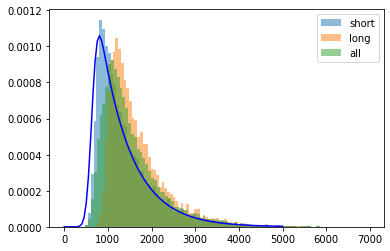

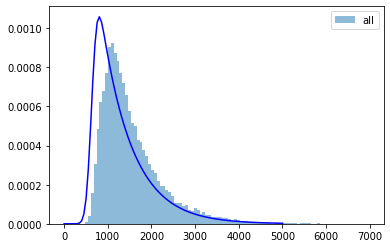

In [8]:

print([sigma_expnorm, mu_expnorm,  lam_expnorm])

print(np.mean(np.concatenate((rt_trials_longer, rt_trials_shorter))))
print('theoretical')
print((mu_expnorm + 1/lam_expnorm)/1000)
x_dist = np.linspace(0, 5000, 100)
shape_expnorm = 1 / (sigma_expnorm * lam_expnorm)
expnorm_pdf_fit_rt_grinband_shift = exponnorm.pdf(x=x_dist, 
                                                    K=shape_expnorm, 
                                                    loc=mu_expnorm,
                                                    scale=sigma_expnorm)

plt.hist(rt_trials_shorter*1000, 100, alpha = .5, label='short', density=True)
plt.hist(rt_trials_longer*1000, 100, alpha = .5, label = 'long', density=True)
plt.hist(np.concatenate((rt_trials_longer*1000, rt_trials_shorter*1000)), 100, alpha = .5, label = 'all', density=True)
plt.plot(x_dist, expnorm_pdf_fit_rt_grinband_shift, 'blue')
plt.legend()
plt.show()


plt.hist(np.concatenate((rt_trials_longer*1000, rt_trials_shorter*1000)), 100, alpha = .5, label = 'all', density=True)
plt.plot(x_dist, expnorm_pdf_fit_rt_grinband_shift, 'blue')
plt.legend()
plt.show()

In [9]:
mods = make_design_matrices_2stim(regs)
#print(mods.keys())
mods['blocked']['Two stimulus types, 2 RT dur only'].shape[0]

336

In [10]:


output, mean_rt = sim_fit_sub_2stim(n_trials,  repetition_time, mu_expnorm,
                      lam_expnorm, sigma_expnorm, max_rt,
                      min_rt, event_duration, ISI_min, ISI_max,
                      win_sub_noise_sd,
                      center_rt, beta_scales_yes,
                      beta_scales_no,
                      rt_diff_s)

In [11]:
#print(output)
print(mean_rt)

{'block1_mean': 1.5871927769492526, 'block2_mean': 2.010353883579013, 'random1_mean': 1.5871927769492526, 'random2_mean': 2.010353883579013}


In [12]:
print(mods.keys())

dict_keys(['blocked', 'random'])


In [ ]:
print(regs.keys())
print(mns)

In [13]:
# look at beta vs rt when model assumes 1s duration
dur_val = 0.1
true_duration = np.arange(0.01, 5, .01)
num_durs = len(true_duration)
est_bold_amplitude_1s = np.empty(true_duration.shape)*np.nan
est_bold_intercept_1s = np.empty(true_duration.shape)*np.nan
est_r2 = np.empty(true_duration.shape)*np.nan
frame_times = np.arange(0, 100, .2)
reg1s, _ = hemodynamic_models.compute_regressor([[5], [dur_val], [1]],
                       'spm', frame_times, oversampling=16)
mod_reg1s = sm.add_constant(reg1s)
for ind, cur_dur in enumerate(true_duration):
    loop_3col_onsets = np.transpose(np.c_[5, cur_dur, 1])
    signal, _ = hemodynamic_models.compute_regressor(loop_3col_onsets,
                       'spm', frame_times, oversampling=16)
    mod_ols = sm.OLS(signal, mod_reg1s).fit() 
    est_bold_amplitude_1s[ind] = mod_ols.params[1]
    est_bold_intercept_1s[ind] = mod_ols.params[0]
    est_r2[ind] = mod_ols.rsquared


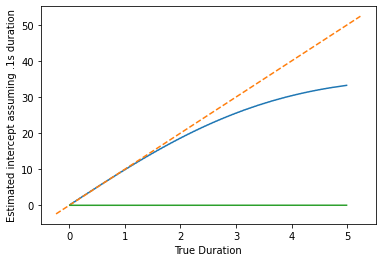

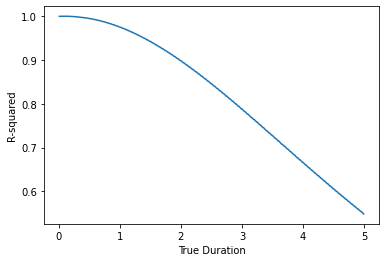

In [16]:

plt.plot(true_duration, est_bold_amplitude_1s)
abline(1/dur_val, 0)
#abline(0,1)
plt.xlabel("True Duration")
plt.ylabel("Estimated BOLD amplitude assuming .1s duration")
#plt.show()
plt.savefig('/Users/jeanettemumford/Dropbox/Research/Writing/RTGroup/Figures/bold_fcn_rt.pdf')


plt.plot(true_duration, est_bold_intercept_1s)
plt.xlabel("True Duration")
plt.ylabel("Estimated intercept assuming .1s duration")
plt.show()

plt.plot(true_duration, est_r2)
plt.xlabel("True Duration")
plt.ylabel("R-squared")
plt.show()



In [ ]:

frame_times = np.arange(0, 40, .2)

dur1a = 1
amp1a = 1
dur1b = 1
amp1b = 1.5

dur2a = 1
amp2a = 1
dur2b = 1.5
amp2b = 1

dur3a = .5
amp3a = 2
dur3b = 1.5
amp3b = 1

reg1a, _ = hemodynamic_models.compute_regressor([[5], [dur1a], [amp1a]],
                       'spm', frame_times, oversampling=16)
reg1b, _ = hemodynamic_models.compute_regressor([[10], [dur1b], [amp1b]],
                       'spm', frame_times, oversampling=16)

reg2a, _ = hemodynamic_models.compute_regressor([[5], [dur2a], [amp2a]],
                       'spm', frame_times, oversampling=16)
reg2b, _ = hemodynamic_models.compute_regressor([[10], [dur2b], [amp2b]],
                       'spm', frame_times, oversampling=16)

reg3a, _ = hemodynamic_models.compute_regressor([[5], [dur3a], [amp3a]],
                       'spm', frame_times, oversampling=16)
reg3b, _ = hemodynamic_models.compute_regressor([[10], [dur3b], [amp3b]],
                       'spm', frame_times, oversampling=16)

plt.plot(frame_times, reg1a, 'g-')
plt.plot(frame_times, reg1b, 'm-')
plt.plot(frame_times, reg2a, 'y-' )
plt.plot(frame_times, reg2b, 'r-' )
plt.plot(frame_times, reg3a, 'y-' )
plt.plot(frame_times, reg3b, 'r-' )
plt.show()

reg1a_n = frame_times*0
reg1a_n[(frame_times>=5) & (frame_times<(5+dur1a))] = amp1a
reg1b_n = frame_times*0
reg1b_n[(frame_times>=10) & (frame_times<(10+dur1b))] = amp1b
reg2a_n = frame_times*0
reg2a_n[(frame_times>=5) & (frame_times<(5+dur2a))] = amp2a
reg2b_n = frame_times*0
reg2b_n[(frame_times>=10) & (frame_times<(10+dur2b))] = amp2b
reg3a_n = frame_times*0
reg3a_n[(frame_times>=5) & (frame_times<(5+dur3a))] = amp3a
reg3b_n = frame_times*0
reg3b_n[(frame_times>=10) & (frame_times<(10+dur3b))] = amp3b

plt.plot(frame_times, reg1a_n, 'g')
plt.plot(frame_times, reg1b_n, 'g')
plt.plot(frame_times, reg2a_n, 'b')
plt.plot(frame_times, reg2b_n, 'b')
plt.show()

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Different underlying neuronal signals yield same BOLD signal",
             fontsize=15)
gs = GridSpec(nrows=3, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(frame_times, reg1a_n)
ax0.plot(frame_times, reg1b_n)
ax0.set_title("Same duration, different amplitude")

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(frame_times, reg2a_n)
ax1.plot(frame_times, reg2b_n)
ax1.set_title("Different duration, same amplitude")

ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(frame_times, reg3a_n)
ax2.plot(frame_times, reg3b_n)
ax2.set_title("Different duration, different amplitude")

ax3 = fig.add_subplot(gs[:, 1])
ax3.plot(frame_times, reg1a)
ax3.plot(frame_times, reg1b)
ax3.set_title("Resulting fMRI signal in all cases")
plt.tight_layout()
#plt.show()
plt.savefig('/Users/jeanettemumford/Dropbox/Research/Writing/RTGroup/Figures/neuron_same_bold.pdf')



In [ ]:

def make_boxcar(frame_times, timing_info):
    bc = frame_times*0
    for ind in range(timing_info.shape[1]):
        trial_onset = timing_info[0,ind]
        trial_dur = timing_info[1,ind]
        trial_amp = timing_info[2, ind]
        bc[(frame_times >= trial_onset) &
           (frame_times < (trial_onset + trial_dur))] = trial_amp
    return bc


frame_times = np.arange(0, 40, .2)    
timing_info = np.array([[5, 20], [2, 2], [1, 1]])
reg_test = make_boxcar(frame_times, timing_info)

ons3col_a = np.array([[5], [.5], [1]])
ons3col_b = np.array([[10], [1], [1]])

bolda, _ = hemodynamic_models.compute_regressor(ons3col_a,
                       'spm', frame_times, oversampling=16)
boldb, _ = hemodynamic_models.compute_regressor(ons3col_b,
                       'spm', frame_times, oversampling=16)

mod_n1a = make_boxcar(frame_times, ons3col_a)
mod_n1b = make_boxcar(frame_times, ons3col_b)
mod_conv1a, _ = hemodynamic_models.compute_regressor(ons3col_a,
                       'spm', frame_times, oversampling=16)
mod_conv1b, _ = hemodynamic_models.compute_regressor(ons3col_b,
                       'spm', frame_times, oversampling=16)

ons3col_2a = np.array([[5], [.5], [1]])
ons3col_2b = np.array([[10], [.5], [1]])
mod_n2a = make_boxcar(frame_times, ons3col_2a)
mod_n2b = make_boxcar(frame_times,  ons3col_2b)
mod_conv2a, _ = hemodynamic_models.compute_regressor(ons3col_2a,
                       'spm', frame_times, oversampling=16)
mod_conv2b, _ = hemodynamic_models.compute_regressor(ons3col_2b,
                       'spm', frame_times, oversampling=16)

anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                 va='center', ha='center', fontsize=15)

small_title_fs = 14

fig = plt.figure(figsize=(20, 5))
fig.suptitle("Same signal, different models, very different conclusions",
             fontsize=20)
gs = GridSpec(nrows=2, ncols=5)

ax0 = fig.add_subplot(gs[:, 0:2])
ax0.plot(frame_times, bolda, label="Condition A")
ax0.plot(frame_times, boldb, label="Condition B")
ax0.set_title("Measured BOLD response\n for two conditions", fontsize=small_title_fs)
ax0.legend()

ax1a = fig.add_subplot(gs[0,2])
ax1a.plot(frame_times, mod_n2a)
ax1a.plot(frame_times, mod_n2b)
ax1a.set_title("Model 1 assumptions:\n duration of response is constant", 
               fontsize=small_title_fs)

ax1b = fig.add_subplot(gs[1,2])
ax1b.plot(frame_times, mod_n1a)
ax1b.plot(frame_times, mod_n1b)
ax1b.set_title("Model 2 assumptions:\n duration of response scales with RT", 
               fontsize=small_title_fs)

ax2a = fig.add_subplot(gs[0,3])
ax2a.plot(frame_times, mod_conv2a)
ax2a.plot(frame_times, mod_conv2b)
ax2a.set_title("Model 1 regressors:\n duration of response is constant",
                fontsize=small_title_fs)

ax2b = fig.add_subplot(gs[1,3])
ax2b.plot(frame_times, mod_conv1a)
ax2b.plot(frame_times, mod_conv1b)
ax2b.set_title("Model 2 regressors:\n duration of response scales with RT", fontsize=small_title_fs)

ax3a = fig.add_subplot(gs[0,4])
ax3a.set_title("Model 1 Results", fontsize=small_title_fs)
ax3a.annotate('Condition B has larger amplitude:\n' r'$\hat{\beta}_{A} < \hat{\beta}_{B}$', **anno_opts)
ax3a.axis('off')
ax3b = fig.add_subplot(gs[1,4])
ax3b.annotate('No amplitude difference:\n' r'$\hat{\beta}_{A} = \hat{\beta}_{B}$', **anno_opts)
ax3b.set_title("Model 2 Results",  fontsize=small_title_fs)
ax3b.axis('off')

plt.tight_layout()
#plt.show()
plt.savefig('/Users/jeanettemumford/Dropbox/Research/Writing/RTGroup/Figures/same_bold_2mods.pdf')

In [ ]:
fig4 = plt.figure(figsize=(10, 5))
#spec4 = fig4.add_gridspec(ncols=2, nrows=2)
gs = GridSpec(nrows=2, ncols=2)
anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                 va='center', ha='center')

f4_ax1 = fig4.add_subplot(gs[0, 0])
f4_ax1.annotate('GridSpec[0, 0]', **anno_opts)
fig4.add_subplot(gs[0, 1]).annotate('GridSpec[0, 1:]', **anno_opts)
fig4.add_subplot(gs[1, 0]).annotate('GridSpec[1:, 0]', **anno_opts)
fig4.add_subplot(gs[1, 1]).annotate('GridSpec[1:, 1:]', **anno_opts)

In [ ]:
fig4 = plt.figure(figsize=(10, 5))
#spec4 = fig4.add_gridspec(ncols=2, nrows=2)
gs = GridSpec(nrows=2, ncols=2)
anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                 va='center', ha='center')

f4_ax1 = fig4.add_subplot(gs[0, 0])
f4_ax1.annotate('GridSpec[0, 0]', **anno_opts)
fig4.add_subplot(gs[0, 1]).annotate('GridSpec[0, 1:]', **anno_opts)
fig4.add_subplot(gs[1, 0]).annotate('GridSpec[1:, 0]', **anno_opts)
fig4.add_subplot(gs[1, 1]).annotate('GridSpec[1:, 1:]', **anno_opts)



fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=2, ncols=2)

ax0 = fig.add_subplot(gs[:, 0])
ax0.plot(frame_times, bolda, label="BOLD condition A")
ax0.plot(frame_times, boldb, label="BOLD condition B")
ax0.set_title("Measured BOLD response\n for two conditions")

ax1a = fig.add_subplot(gs[0,1])
ax1a.annotate('No amplitidue difference', **anno_opts)
ax1a.axis('off')
ax1b = fig.add_subplot(gs[1,1])
ax1b.annotate('Task B has larger amplitude', **anno_opts)


In [ ]:
#Illustrating model misfit as RT increases

true_duration = np.arange(0.01, 2, .1)
num_durs = len(true_duration)
onsets=np.arange(10, (30*num_durs+9), 30)
const_imp = np.ones(true_duration.shape)*.1
const_one = np.ones(true_duration.shape)
frame_times = np.arange(0, max(onsets+30), .2)
reg_dur, _ = hemodynamic_models.compute_regressor(
                       [onsets, true_duration, const_one],
                       'spm', frame_times, oversampling=16)
reg_mod, _ = hemodynamic_models.compute_regressor(
                       [onsets, const_one, true_duration],
                       'spm', frame_times, oversampling=16)

x_mod = sm.add_constant(reg_mod)
mod_ols = sm.OLS(reg_dur, x_mod).fit() 
slope_est = mod_ols.params[1]
int_est = mod_ols.params[0]

plt.plot(frame_times, reg_dur, label='RT Duration')
plt.plot(frame_times, slope_est*reg_mod + int_est, 
         label='Fit of RT mod (dur=1s) to RT Duration')
plt.title("Duration vs Modulation, RT between 0-2s")
plt.legend()
plt.show()

In [ ]:
true_duration = np.array([.25, .5, 1.25, 1.5])
num_durs = len(true_duration)
onsets=np.arange(10, (30*num_durs+9), 30)
const_imp = np.ones(true_duration.shape)*.1
const_one = np.ones(true_duration.shape)
frame_times = np.arange(0, max(onsets+30), .2)
true_duration_centered = true_duration - np.mean(true_duration)
reg_cons, _ = hemodynamic_models.compute_regressor(
                       [onsets, const_one, const_one],
                       'spm', frame_times, oversampling=16)
reg_consa, _ = hemodynamic_models.compute_regressor(
                       [onsets[:2], const_one[:2], const_one[:2]],
                       'spm', frame_times, oversampling=16)
reg_consb, _ = hemodynamic_models.compute_regressor(
                       [onsets[-2:], const_one[-2:], const_one[-2:]],
                       'spm', frame_times, oversampling=16)
reg_mod, _ = hemodynamic_models.compute_regressor(
                       [onsets, const_one, true_duration_centered],
                       'spm', frame_times, oversampling=16)
reg_mod_sub_0, _ = hemodynamic_models.compute_regressor(
                       [onsets, const_one, (true_duration - 0)],
                       'spm', frame_times, oversampling=16)
reg_mod_sub_25, _ = hemodynamic_models.compute_regressor(
                       [onsets, const_one, (true_duration - .25)],
                       'spm', frame_times, oversampling=16)
reg_dura, _ = hemodynamic_models.compute_regressor(
                       [onsets[:2], true_duration[:2], const_one[:2]],
                       'spm', frame_times, oversampling=16)
reg_durb, _ = hemodynamic_models.compute_regressor(
                       [onsets[-2:], true_duration[-2:], const_one[-2:]],
                       'spm', frame_times, oversampling=16)
plt.plot(frame_times, reg_cons)
plt.plot(frame_times, reg_mod, label="modulation = mean centered RT (mean = .5)")
plt.plot(frame_times, reg_mod_sub_25, label="modulation = RT- .25")
plt.legend()
plt.show()

plt.plot(frame_times, reg_consa)
plt.plot(frame_times, reg_consb)
plt.show()


plt.plot(frame_times, reg_dura)
plt.plot(frame_times, reg_durb)
plt.show()



In [ ]:
#True signal scales with RT, but has amplitude differences

y = reg_dura + 2*reg_dura + np.random.normal(0, 1, reg_dura.shape)
des1 = np.concatenate((reg_consa, reg_consb, reg_mod_sub_0), axis =1)

des_nocentering = sm.add_constant(des1)
des_nocentering = pd.DataFrame(des_nocentering, columns=['intercept', 'taskA', 'taskB', 'RT mod(no center)'])
mod_nocentering = sm.OLS(y, des_nocentering).fit() 
contrast = np.array([0, -1, 1, 0])
print(mod_nocentering.t_test(contrast))


des2 = np.concatenate((reg_consa, reg_consb, reg_mod), axis =1)
des_centering = sm.add_constant(des2)
des_centering = pd.DataFrame(des_centering, columns=['intercept', 'taskA', 'taskB', 'RT mod(yes center)'])
mod_centering = sm.OLS(y, des_centering).fit() 
contrast = np.array([0, -1, 1, 0])
print(mod_centering.t_test(contrast))

print(mod_nocentering.summary())
print(mod_centering.summary())


In [ ]:

bold_diff = np.array([.2, .7, .1])
rt_diff = np.array([.2, .7, .1])

plt.plot(rt_diff, bold_diff, 'bo')
plt.xlabel("RT diff")
plt.ylabel("Condition diff")
abline(1, 0)
plt.show()

In [ ]:
samp1 = np.random.choice(np.arange(0, num_durs), num_durs)
samp2 = np.random.choice(np.arange(0, num_durs), num_durs)

rt_diff = true_duration[samp2] -true_duration[samp1]
bold_diff = est_bold_amplitude_1s[samp2] - est_bold_amplitude_1s[samp1]

desmat_diff = sm.add_constant(rt_diff)
mod_diff = sm.OLS(bold_diff, desmat_diff).fit()
print(mod_diff.summary()) 

plt.plot(rt_diff, bold_diff, 'o')
abline(mod_diff.params[1], mod_diff.params[0])
plt.xlabel("RT difference")
plt.ylabel("BOLD activation difference")
plt.show


In [ ]:

nsub = 30
n_trials = 80
scan_length = 400
repetition_time = 1
mu_grinband_shift = 638
inv_lambda_grinband_shift = 699
sigma_grinband_shift = 103
mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift
#Stroop settings
#mu_expnorm = 530
#lam_expnorm = 1 / 160
#sigma_expnorm = 77
max_rt = 8000
min_rt = 50
event_duration = .1  
center_rt=True
hp_filter = True
ISI_min = 3
ISI_max = 6
nsim_sd_est = 100
nsim_power = 1000



In [ ]:
# checking that my samples acutally look like the distribution
shape_expnorm = 1 / (sigma_expnorm * lam_expnorm)
nsim = 10000
rt_diff_s = 0
mn_rt_sim = np.repeat(np.nan, nsim)
diff_mn_rt_sim = np.repeat(np.nan, nsim)
for i in range(nsim):
    sim_num_trials = 0
    while sim_num_trials < n_trials:
        subject_specific_mu_expnorm_short = exponnorm.rvs(shape_expnorm, mu_expnorm,
                                                sigma_expnorm, 1) - \
                                                1 / lam_expnorm
        #subject_specific_mu_expnorm_long = exponnorm.rvs(shape_expnorm, mu_expnorm+(rt_diff_s*1000),
        #                                        sigma_expnorm, 1) - \
        #                                        1 / lam_expnorm
        subject_specific_mu_expnorm_long = subject_specific_mu_expnorm_short +\
                                         rt_diff_s * 1000
                                         #np.random.normal(rt_diff_s, .1, 1)*1000  
#        subject_specific_mu_expnorm = np.random.normal(mu_expnorm, 90, 1)
        rt_trials_twice_what_needed_shorter = exponnorm.rvs(shape_expnorm,
                                                subject_specific_mu_expnorm_short,
                                                sigma_expnorm, n_trials)
        rt_trials_filtered_shorter = rt_trials_twice_what_needed_shorter[
            np.where((rt_trials_twice_what_needed_shorter < max_rt) &
                 (rt_trials_twice_what_needed_shorter > min_rt))]
        rt_trials_twice_what_needed_longer = exponnorm.rvs(shape_expnorm,
                                                subject_specific_mu_expnorm_long,
                                                sigma_expnorm, n_trials)
        rt_trials_filtered_longer = rt_trials_twice_what_needed_longer[
            np.where((rt_trials_twice_what_needed_longer < max_rt) &
                 (rt_trials_twice_what_needed_longer > min_rt))]
        sim_num_trials = (subject_specific_mu_expnorm_short>0) *\
                         (subject_specific_mu_expnorm_long>0) *\
                         (rt_trials_filtered_shorter.shape[0]> int(n_trials/2)) * \
                         (rt_trials_filtered_longer.shape[0] > int(n_trials/2))*n_trials
    rt_trials_shorter = rt_trials_filtered_shorter[:int(n_trials/2)] / 1000
    rt_trials_longer = rt_trials_filtered_longer[:int(n_trials/2)] / 1000
    rt_trials = np.concatenate((rt_trials_shorter, rt_trials_longer))
    mn_rt_sim[i] = np.mean(rt_trials)
    diff_mn_rt_sim[i] = np.mean(rt_trials_longer)-np.mean(rt_trials_shorter)

print(np.mean(diff_mn_rt_sim))
plt.hist(diff_mn_rt_sim)
plt.show

In [ ]:
print(rt_diff_s)
print(np.min(mn_rt_sim))

#mn_rt_sim = exponnorm.rvs(shape_expnorm, mu_expnorm+(rt_diff_s*1000),
#                                                sigma_expnorm, 1000)/1000
#print(mn_rt_sim.shape)

x_dist = np.linspace(0, 5000, 100)
expnorm_pdf_fit_rt_grinband_shift = exponnorm.pdf(x=x_dist, 
                                                    K=shape_expnorm, 
                                                    loc=mu_expnorm,
                                                    scale=sigma_expnorm)

plt.hist(mn_rt_sim*1000, 100, density=True)
plt.plot(x_dist, expnorm_pdf_fit_rt_grinband_shift, 'green')
plt.show



In [ ]:
shape2, mu2, sigma2  = exponnorm.fit(mn_rt_sim*1000)
print(shape2)
print(mu2)
print(sigma2)

In [ ]:
#look at percent change (to inform beta choice)
# No variance for this.
rt_diff_s = 0
#beta_scales_yes = np.array([.2, .2])
#beta_scales_no = np.array([.3, .3])

beta_scales_yes = np.array([.5, .5])
beta_scales_no = np.array([.5, .5])
win_sub_noise_sd={'dv_scales_yes': .8, 'dv_scales_no': .09}
#btwn_sub_noise_sd={'dv_scales_yes': .2, 'dv_scales_no': .2}
btwn_sub_noise_sd={'dv_scales_yes': .4, 'dv_scales_no': .6}




perch_out = est_per_change_2stim(n_trials, scan_length, 
                                   repetition_time, mu_expnorm, 
                                   lam_expnorm, sigma_expnorm,
                                   max_rt, min_rt, event_duration, ISI_min, 
                                   ISI_max, center_rt, rt_diff_s,
                                   beta_scales_yes, beta_scales_no)
print(perch_out)

In [ ]:
#win_sub_noise_sd={'dv_scales_yes': .3, 'dv_scales_no': .03}
#btwn_sub_noise_sd={'dv_scales_yes': .1, 'dv_scales_no': .1}
rt_diff = 0
nsim = 500

#IMPORTANT:  sd_ratio_out is for the beta_difference contrast, while the eff_size is level 1 individual beta eff size.
# sd ratio is total to within
sd_ratio_out, eff_size_out = est_var_ratio_eff_size_2stim(n_trials, scan_length, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, 
              win_sub_noise_sd,
              btwn_sub_noise_sd,
              beta_scales_yes, 
              beta_scales_no, 
              center_rt, 
              rt_diff_s, nsim)

In [ ]:
print(sd_ratio_out['dv_scales_yes']['blocked']['Two stimulus types, 2 RT dur only'])
print(sd_ratio_out['dv_scales_yes']['random']['Two stimulus types, 2 RT dur only'])
print(sd_ratio_out['dv_scales_no']['blocked']['Two stimulus types, no RT'])
print(sd_ratio_out['dv_scales_no']['random']['Two stimulus types, no RT'])

In [ ]:
#print('sd ratio')
#print(sd_ratio_out)
print('effect size')
print(eff_size_out)

In [ ]:
# look at distribution of rt_diff
rt_diff_s = 0.25

nsim = 1
nsub = 50
output_cor = group_2stim_rt_cor(n_trials, scan_length, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, 
              win_sub_noise_sd,
              btwn_sub_noise_sd, 
              center_rt, beta_scales_yes, beta_scales_no,  
              rt_diff_s, nsub, nsim)

In [ ]:
output_cor['rt_diffs_last_sim']
plt.hist(output_cor['rt_diffs_last_sim']['blocked'])
plt.show()
plt.hist(output_cor['rt_diffs_last_sim']['random'])
plt.show()

print(np.mean(output_cor['rt_diffs_last_sim']['random']))

In [ ]:
# Correlation with RT for 2back vs 0back correlations are as high as .2
rt_diff_s = 0.6


beta_scales_yes = np.array([0, 3])
beta_scales_no = np.array([.3, .3])
#win_sub_noise_sd={'dv_scales_yes': .3, 'dv_scales_no': .03}
btwn_sub_noise_sd={'dv_scales_yes': .1, 'dv_scales_no': .1}
nsim = 100
nsub = 30
output_cor = group_2stim_rt_cor(n_trials, scan_length, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, 
              win_sub_noise_sd,
              btwn_sub_noise_sd, 
              center_rt, beta_scales_yes, beta_scales_no,  
              rt_diff_s, nsub, nsim)

In [ ]:
print(output_cor.keys())
#print("RT mean")
#print(output_cor['group_mn_cor_rtmean'])
print("RT diff")

print(output_cor['group_mn_cor_rtdiff'])
#.10

In [ ]:
rt_diff_s = 2
regs, rt_mns  = make_regressors_two_trial_types(n_trials, scan_length,
                                   repetition_time, mu_expnorm,
                                   lam_expnorm, sigma_expnorm,
                                   max_rt, min_rt, event_duration, 
                                   ISI_min, ISI_max, center_rt, 
                                   rt_diff_s)

In [ ]:
print(rt_mns)

In [ ]:
print(regs.keys())
plt.plot(regs['stim1_blocked'])
plt.plot(regs['stim2_blocked'], 'green')
plt.show()

plt.plot(regs['rt_mod_2stim_blocked'])
plt.show()

plt.plot(regs['stim1_random'])
plt.plot(regs['stim2_random'], 'green')
plt.show()

plt.plot(regs['rt_mod_2stim_random'])
plt.show()

plt.plot(regs['rt_dur_2stim_blocked'])
plt.show()

plt.plot(regs['rt_dur_2stim_random'])
plt.show()

plt.plot(regs['rt_dur_2stim_blocked1'])
plt.plot(regs['rt_dur_2stim_blocked2'], 'green')
plt.title('Two RT dur regressors')
plt.show()

plt.plot(regs['rt_dur_2stim_random1'])
plt.plot(regs['rt_dur_2stim_random2'], 'green')
plt.show()


In [ ]:
print(rt_mns)
print((rt_mns['block1_mean']+rt_mns['block2_mean'])/2)
print((rt_mns['random1_mean']+rt_mns['random2_mean'])/2)

In [ ]:
nsim = 1000
rt_diff_s = 0.1


#rej_rate_out = rejection_rate_1sub_2stim(n_trials, scan_length, repetition_time, mu_expnorm,
#              lam_expnorm, sigma_expnorm, max_rt, 
#              min_rt, event_duration, ISI_min, ISI_max, 
#              win_sub_noise_sd['dv_scales_yes'], win_sub_noise_sd['dv_scales_no'], 
#              center_rt, beta_scales_yes, beta_scales_no, 
#              rt_diff_s, nsim)

In [ ]:
#print(rej_rate_out['blocked'])
#print(rej_rate_out['random'])

In [2]:
nsub = 100
n_trials = 80
repetition_time = 1
mu_grinband_shift = 638
inv_lambda_grinband_shift = 699
sigma_grinband_shift = 103
mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift
max_rt = 8000
min_rt = 50
event_duration = .1  
center_rt=False
hp_filter = True


win_sub_noise_sd={'dv_scales_yes': 1.15, 'dv_scales_no': .09}
btwn_sub_noise_sd={'dv_scales_yes': .65, 'dv_scales_no': .75}

beta_scales_yes = np.array([.75, .75])
beta_scales_no= np.array([.85, .85])
ISI_min = 2
ISI_max = 4
nsim = 1000

In [4]:
rt_diff_s_vec = [.2]
output = group_2stim_rt_diff_vec(n_trials, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, 
              win_sub_noise_sd,
              btwn_sub_noise_sd, 
              center_rt, beta_scales_yes, beta_scales_no,  
              rt_diff_s_vec, nsub, nsim)

In [ ]:
print(output.keys())
print(output)

In [ ]:
# make it long form pandas
data_type = ['blocked', 'random']
models = ['Two stimulus types, no RT', 'Two stimulus types, RT mod', 'Two stimulus types, 2 RT dur only']
scale_type = ['dv_scales_yes', 'dv_scales_no']


data_type_long = []
models_long = []
scale_type_long = []
rej_rate_beta_diff = []
rt_diff_long = []

for cur_data_type in data_type:
    for cur_model in models:
        for cur_scale_type in scale_type:
            rej_rate_loop = output['group_rej_rate'][cur_data_type][cur_model]\
                                            [cur_scale_type]['beta_diff_est']
            nvals = len(rej_rate_loop)
            data_type_long.extend([cur_data_type] * nvals)
            models_long.extend([cur_model] * nvals)
            scale_type_long.extend([cur_scale_type] * nvals)
            rej_rate_beta_diff.extend(rej_rate_loop)
            rt_diff_long.extend(output['rt_diff'] * nvals)


data_long = pd.DataFrame(list(zip(rt_diff_long, data_type_long, models_long, \
                            scale_type_long,rej_rate_beta_diff)),
            columns = ['RT diff','Data Type', 'Model', 'Scale Type', \
                 'Rejection Rate'])


In [ ]:
# violin plot code for correlations

dat_plot = all_correlations[(all_correlations['Correlation Type'] == 'group_rtdiff_cor') &
                            (all_correlations['Data Type'] == 'random') &
                            (all_correlations['Beta Contrast'] == 'beta_diff_est')]

plt.figure(figsize=(8, 6))
sns.violinplot(data = dat_plot,  x='Model', y='Correlation', hue='Scale Type')
plt.show

In [ ]:
import seaborn as sns
sns.relplot(data = data_long, x='RT diff', y='Rejection Rate', 
            hue = 'Model', style = 'Data Type', col = 'Scale Type',
            kind = 'line')

POWER


In [ ]:
#POWER
rt_diff = 0.25
nsim = 500
nsub=30
beta_scales_yes={'beta1': .5, 'beta2': [.5, .8]}
beta_scales_no={'beta1': .5, 'beta2': [.5, .8]}
output_power = group_2stim_beta2_vec(n_trials, scan_length, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, 
              win_sub_noise_sd,
              btwn_sub_noise_sd,
              center_rt, beta_scales_yes,
              beta_scales_no, 
              rt_diff_s, nsub, nsim)

In [ ]:
#print(output_power['group_rej_rate']['blocked'])
#print('')
#print(output_power['group_rej_rate']['random'])
print(beta_scales_yes)
print(beta_scales_no)
for key, item in output_power['group_rej_rate'].items():
    for key2, item2 in item.items():
        for key3, item3 in item2.items():
            print(f'{key}: {key2}: {key3}')
            print(item3)


In [ ]:
print(len(scale_type_long))
print(len(data_type_long))
print(len(models_long))
print(len(rej_rate_beta_diff))

print(data_long.shape)
print(data_long.columns)

data_blocked = data_long[data_long["Data Type"] == 'blocked']
print(data_blocked.shape)

In [ ]:
print(beta_scales_yes)
print(beta_scales_no)
print(rt_diff_s)
print(output.keys())
print('RT diff')
print(output['group_mn_cor_rtdiff'])
print('RT mean')
print(output['group_mn_cor_rtmean'])
print('Rejection rates')
print(output['group_rej_rate'])

In [ ]:
nsub = 50
nsim = 100
rt_diff_s = .75
win_sub_noise_sd_scales_yes = .1
win_sub_noise_sd_scales_no = .1
btwn_sub_noise_sd_scales_yes = .5
btwn_sub_noise_sd_scales_no = .5
ISI_min = 1
ISI_max = 3

output = group_2stim(n_trials, scan_length, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, 
              win_sub_noise_sd_scales_yes, win_sub_noise_sd_scales_no,
              btwn_sub_noise_sd_scales_yes, btwn_sub_noise_sd_scales_no, 
              center_rt, beta_scales_yes, beta_scales_no,  
              rt_diff_s, nsub, nsim)

In [ ]:
print('RT diff')
print(output['group_mn_cor_rtdiff'])
print('RT mean')
print(output['group_mn_cor_rtmean'])
print('Rejection rates')
print(output['group_rej_rate'])

In [ ]:


from nilearn.plotting import plot_design_matrix
#type(pd.DataFrame(desmats['Two Stimlus types, RT mod (blocked)']))
#plot_design_matrix(pd.DataFrame(desmats['Two Stimlus types, RT mod (blocked)']))

fig, axs = plt.subplots(figsize=(10, 3), nrows=1, ncols=3)
i= 0
for des in desmats['blocked']:
    #print(pd.DataFrame(desmats[des]))
    plot_design_matrix(pd.DataFrame(desmats['blocked'][des]), ax = axs[i])
    i = i + 1
plt.show()

fig, axs = plt.subplots(figsize=(10, 3), nrows=1, ncols=3)

i= 0
for des in desmats['random']:
    #print(pd.DataFrame(desmats[des]))
    plot_design_matrix(pd.DataFrame(desmats['random'][des]), ax = axs[i])
    i = i + 1
plt.show()

for name, des in desmats['random'].items():
    print(name)
    print(des)

In [ ]:
print(desmats['blocked']['Two stimulus types, 2 RT dur only'][1:10,1])
print(desmats['blocked']['Two stimulus types, 2 RT dur only'])

In [ ]:


plt.plot(np.array(beta_impulse)/10, dur_vec, 'o')
plt.xlabel('beta impulse regressor / 10')
plt.ylabel('Stimulus duration')
abline(1, 0)
plt.show()
plt.plot(beta_1s, dur_vec, 'o')
plt.xlabel('beta 1s duration regressor')
plt.ylabel('Stimulus duration')
abline(1, 0)
plt.show()

plt.plot(dur_vec, res_impulse, label='impulse')
plt.plot(dur_vec, res_1s, label='1s')
plt.xlabel('Stimulus duration')
plt.ylabel('Sum of squared residuals')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

So it seems that the 1s duration regressor is less susceptible to misfitting the data, in the range we'd expect RTs to be.  Also, the interpretation of the parameter estimate seems to match up well with the duration.  This is helpful, but I need to further understand the behavior for a range of trials with a range of RTs within a single run.  Here I only looked at a single trial.

In [ ]:
frame_times = np.arange(50)
scan_length = len(frame_times)
onsets = [20]
duration_rt1 = [2]
amplitude_1 = [1]

duration_rt2 = 1
amplitude_2 = [2]


dur_2_amp_1, _ = hemodynamic_models.compute_regressor(
                      make_3column_onsets(onsets, duration_rt1, amplitude_1), 
                      'spm', frame_times, oversampling=16)
dur_1_amp_2, _ = hemodynamic_models.compute_regressor(
                      make_3column_onsets(onsets, duration_rt2, amplitude_2), 
                      'spm', frame_times, oversampling=16)
plt.plot(dur_2_amp_1, label = 'Duration =2s, Amplitude = 1')
plt.plot(dur_1_amp_2, label = 'Duration =1s, Amplitude = 2')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()


frame_times = np.arange(50)
scan_length = len(frame_times)
onsets = [20]
duration_rt1 = [1]
amplitude_1 = [1]

duration_rt2 = 1.5
amplitude_2 = [1]


reg1, _ = hemodynamic_models.compute_regressor(
                      make_3column_onsets(onsets, duration_rt1, amplitude_1), 
                      'spm', frame_times, oversampling=16)
reg2, _ = hemodynamic_models.compute_regressor(
                      make_3column_onsets(onsets, duration_rt2, amplitude_2), 
                      'spm', frame_times, oversampling=16)
plt.plot(reg1, label = 'RT duration')
plt.plot(reg2, label = 'Stimulus duration')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

np.corrcoef(reg1.T, reg2.T)


frame_times = np.arange(50)
scan_length = len(frame_times)
onsets = [20]
duration_rt1 = [1]
amplitude_1 = [1]

onsets2 = 21
duration_rt2 = .5
amplitude_2 = [1]


reg1, _ = hemodynamic_models.compute_regressor(
                      make_3column_onsets(onsets, duration_rt1, amplitude_1), 
                      'spm', frame_times, oversampling=16)
reg2, _ = hemodynamic_models.compute_regressor(
                      make_3column_onsets(onsets2, duration_rt2, amplitude_2), 
                      'spm', frame_times, oversampling=16)
plt.plot(reg1, label = 'RT duration')
plt.plot(reg2, label = 'Tail end of stimulus duration')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

np.corrcoef(reg1.T, reg2.T)

In [ ]:
frame_times = np.arange(100)
scan_length = len(frame_times)
onsets = np.arange(10, 50, 3)
#onsets = 10
print(onsets)
duration_rt = [2]*len(onsets)
#duration_rt = 30
print(duration_rt)
amplitude_1 = [1]*len(onsets)

des_3col = make_3column_onsets(onsets, duration_rt, amplitude_1)

reg_unconv, _ = hemodynamic_models.compute_regressor(
                      des_3col, None, frame_times, 
                      oversampling=16)
reg, _ = hemodynamic_models.compute_regressor(
                      des_3col, 'spm', frame_times, 
                      oversampling=16)

plt.plot(reg)
plt.plot(reg_unconv)
plt.show

In [ ]:
# Teasing apart possible parameter interpretation
frame_times = np.arange(500)
scan_length = len(frame_times)
onsets = np.arange(10, 480, 10)

duration_rt = gamma.rvs(a = 1.7, loc = .5, scale = .49, size = onsets.shape)
amplitude_1 = np.ones(onsets.shape)
mn_rt = np.mean(duration_rt)
#duration_cons = [mn_rt, mn_rt, mn_rt]
duration_cons = np.ones(onsets.shape)
amplitude_rt_centered = duration_rt - np.mean(duration_rt)
mn_rt_dur = np.ones(onsets.shape)*mn_rt

rt_dur_reg_info = make_3column_onsets(onsets, duration_rt, amplitude_1)
unmod_reg_info = make_3column_onsets(onsets, duration_cons, amplitude_1)
mod_rt_centered_reg_info = make_3column_onsets(onsets, duration_cons, amplitude_rt_centered)

mn_rt_dur_reg_info = make_3column_onsets(onsets, mn_rt_dur, amplitude_1)

rt_dur, _ = hemodynamic_models.compute_regressor(
                      rt_dur_reg_info, 'spm', frame_times, 
                      oversampling=16)
mn_rt_dur, _ = hemodynamic_models.compute_regressor(
                      mn_rt_dur_reg_info, 'spm', frame_times, 
                      oversampling=16)
unmod_reg, _ = hemodynamic_models.compute_regressor(
                      unmod_reg_info, 'spm', frame_times, 
                      oversampling=16)
mod_rt, _ = hemodynamic_models.compute_regressor(
                      mod_rt_centered_reg_info, 'spm', frame_times, 
                      oversampling=16)
# orthogonalize by first fitting unmod to rt_dur
x_unmod_only = sm.add_constant(unmod_reg)
#contrasts = np.array([[0, 1]])
#_, _, _, predy, _ = runreg(rt_dur, x_unmod_only, contrasts, hp_filter=False, 
#                           compute_stats=False)
contrasts = np.array([[1]])
_, _, _, predy, _ = runreg(rt_dur, unmod_reg, contrasts, hp_filter=False, 
                           compute_stats=False)
#rt_dur_orth = rt_dur - predy
rt_dur_orth_reg_info = make_3column_onsets(np.array(onsets)+1, 
                                           np.array(duration_rt)-1, amplitude_1)
rt_dur_orth, _ = hemodynamic_models.compute_regressor(
                      rt_dur_orth_reg_info, 'spm', frame_times, 
                      oversampling=16)  


bold = 100 + rt_dur*5 + np.random.normal(0, 0, (scan_length, 1))
contrasts = np.array([[1, 0], [0, 1]])
x_rt_dur = sm.add_constant(rt_dur)
con_dur_rt, t_dur_rt, p_dur_rt, mod_fit_dur_rt, _ = runreg(bold, x_rt_dur, 
                                contrasts, hp_filter=False, compute_stats=True)
print('RT dur model')
print(con_dur_rt)
#print(p_dur_rt)

contrasts = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_cons_rt = np.concatenate((np.ones(unmod_reg.shape), unmod_reg, rt_dur_orth), axis=1)
con_cons_rt, t_cons_rt, p_cons_rt, mod_fit_cons_rt, _ = runreg(bold, x_cons_rt, contrasts, hp_filter=False, compute_stats=True)
print('Unmodulated and Orthogonalized RT dur')
print(con_cons_rt)
#print(p_cons_rt)

x_cons_rt_mod = np.concatenate((np.ones(unmod_reg.shape), unmod_reg, mod_rt), axis=1)
con_cons_rt_mod, t_cons_rt_mod, p_cons_rt_mod, mod_fit_cons_rt_mod, _ = runreg(bold, x_cons_rt_mod, contrasts, hp_filter=False, compute_stats=True)
print('Unmodulated and RT-modulated (centered RT)')
print(con_cons_rt_mod)
#print(p_cons_rt_mod)

print(mn_rt)

fit_cons_dur_only = con_cons_rt[0] + con_cons_rt[1]*unmod_reg

#plt.plot(bold, label = 'data')
#plt.plot(mod_fit_dur_rt, label = 'model fit var epoch')
#plt.plot(mod_fit_cons_rt, label='model fit cons dur + orthog var epoch')
#plt.plot(mod_fit_cons_rt_mod, label='model fit cons dur + rt mod')
#plt.plot(fit_cons_dur_only, label='only cons dur from cons dur + rt mod')
#plt.legend(loc = 'upper left', prop={'size': 6})
#plt.show()

#plt.plot(con_dur_rt[0] + mn_rt_dur*con_dur_rt[1], 
#        label='intercept + mn rt x rt_dur (rt dur model)')
#plt.plot(fit_cons_dur_only, label = 'only cons dur from cons dur + rt mod')
#plt.legend(loc = 'upper right', prop={'size': 6})
#plt.show()





In [ ]:
def sim_est_beta_rt_shift(gamma_loc, gamma_alpha, gamma_beta, cons_dur_val, nsim):
    """
    """
    sim_out = {"beta_rt", "beta_cons_orth", "beta_rt_orth",
               "beta_cons_mod", "beta_rt_mod", "beta_cons_dur_mn_rt", "beta_rt_dur_mn_rt",
               "p_rt", "p_cons_orth", "p_rt_orth",
               "p_cons_mod", "p_rt_mod", "p_cons_dur_mn_rt", "p_rt_dur_mn_rt", "mn_rt_all"}
    output_dict = {key: [] for key in sim_out} 
    for sim in range(0, nsim):
        frame_times = np.arange(500)
        scan_length = len(frame_times)
        onsets = np.arange(10, 480, 10)
        duration_rt = gamma.rvs(a = gamma_alpha, loc = gamma_loc, scale = gamma_beta, size = onsets.shape)
        amplitude_1 = np.ones(onsets.shape)
        mn_rt = np.mean(duration_rt)
        output_dict["mn_rt_all"].append(round(mn_rt, 5))
        duration_cons = np.ones(onsets.shape)*cons_dur_val
        duration_impulse = np.ones(onsets.shape)*.1 
        amplitude_rt_centered = duration_rt - mn_rt
        mn_rt_dur = np.ones(onsets.shape)*mn_rt
        rt_dur_reg_info = make_3column_onsets(onsets, duration_rt, amplitude_1)
        unmod_mnrt_dur_reg_info = make_3column_onsets(onsets, mn_rt_dur, amplitude_1)
        imp_reg_info = make_3column_onsets(onsets, duration_impulse, amplitude_1)
        unmod_reg_info = make_3column_onsets(onsets, duration_cons, amplitude_1)
        mod_rt_centered_reg_info = make_3column_onsets(onsets, duration_cons, amplitude_rt_centered)
        
        rt_dur, _ = hemodynamic_models.compute_regressor(
                      rt_dur_reg_info, 'spm', frame_times, 
                      oversampling=16)
        imp_dur, _ = hemodynamic_models.compute_regressor(
                      imp_reg_info, 'spm', frame_times, 
                      oversampling=16)
        unmod_reg, _ = hemodynamic_models.compute_regressor(
                      unmod_reg_info, 'spm', frame_times, 
                      oversampling=16)
        unmod_mnrt_dur_reg, _ = hemodynamic_models.compute_regressor(
                      unmod_mnrt_dur_reg_info, 'spm', frame_times, 
                      oversampling=16)
        mod_rt, _ = hemodynamic_models.compute_regressor(
                      mod_rt_centered_reg_info, 'spm', frame_times, 
                      oversampling=16)
        # orthogonalize by first fitting unmod to rt_dur
        #x_unmod_only = sm.add_constant(unmod_reg)
        #contrasts = np.array([[0, 1]])
        #_, _, _, predy, _ = runreg(rt_dur, x_unmod_only, contrasts, hp_filter=False, 
        #                           compute_stats=False)
        contrasts = np.array([[1]])
        _, _, _, predy, _ = runreg(rt_dur, unmod_reg, contrasts, hp_filter=False, 
                           compute_stats=False)
        rt_dur_orth = rt_dur - predy
        # Same as above, but for mn_rt_dur regressor
        _, _, _, predy, _ = runreg(rt_dur, unmod_mnrt_dur_reg, contrasts, hp_filter=False, 
                           compute_stats=False)
        rt_dur_orth_mnrt_dur = rt_dur - predy
        # Orthogonalize in neural space (sort of)
        #rt_dur_orth_reg_info = make_3column_onsets(np.array(onsets)+cons_dur_val, 
        #                                   np.array(duration_rt)-cons_dur_val, amplitude_1)
        #
        #rt_dur_orth_reg_info = make_3column_onsets(np.array(onsets), 
        #                                   duration_rt, amplitude_1)
        #rt_dur_orth, _ = hemodynamic_models.compute_regressor(
        #              rt_dur_orth_reg_info, 'spm', frame_times, 
        #              oversampling=16)  
        bold = 100 + rt_dur*5 + np.random.normal(0, 5, (scan_length, 1))
        contrasts = np.array([[1, 0], [0, 1]])
        x_rt_dur = sm.add_constant(rt_dur)
        con_dur_rt, t_dur_rt, p_dur_rt, mod_fit_dur_rt, _ = runreg(bold, x_rt_dur, 
                                contrasts, hp_filter=False, compute_stats=True)
        output_dict["beta_rt"].append(round(con_dur_rt[1], 3))
        output_dict["p_rt"].append(p_dur_rt[1])

        contrasts = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        x_cons_rt = np.concatenate((np.ones(unmod_reg.shape), unmod_reg, rt_dur_orth), axis=1)
        con_cons_rt, t_cons_rt, p_cons_rt, mod_fit_cons_rt, _ = runreg(bold, x_cons_rt, contrasts,
                  hp_filter=False, compute_stats=True)
        output_dict["beta_cons_orth"].append(round(con_cons_rt[1], 3))
        output_dict["beta_rt_orth"].append(round(con_cons_rt[2], 3))
        output_dict["p_cons_orth"].append(p_cons_rt[1])
        output_dict["p_rt_orth"].append(p_cons_rt[2])

        x_cons_rt_mod = np.concatenate((np.ones(unmod_reg.shape), unmod_reg, mod_rt), axis=1)
        con_cons_rt_mod, t_cons_rt_mod, p_cons_rt_mod, mod_fit_cons_rt_mod, _ = runreg(bold, 
                  x_cons_rt_mod, contrasts, hp_filter=False, compute_stats=True)
        output_dict["beta_cons_mod"].append(round(con_cons_rt_mod[1], 3))
        output_dict["beta_rt_mod"].append(round(con_cons_rt_mod[2], 3))
        output_dict["p_cons_mod"].append(p_cons_rt_mod[1])
        output_dict["p_rt_mod"].append(p_cons_rt_mod[2])

        x_consmnrt_rt_mod = np.concatenate((np.ones(unmod_reg.shape),
                                           unmod_mnrt_dur_reg,
                                           rt_dur_orth_mnrt_dur), axis=1)
        con_consmnrt_rt_mod, t_consmnrt_rt_mod, p_consmnrt_rt_mod, mod_fit_consmnrt_rt_mod, _ = runreg(bold, 
                  x_consmnrt_rt_mod, contrasts, hp_filter=False, compute_stats=True)
        output_dict["beta_cons_dur_mn_rt"].append(round(con_consmnrt_rt_mod[1], 3))
        output_dict["beta_rt_dur_mn_rt"].append(round(con_consmnrt_rt_mod[2], 3))
        output_dict["p_cons_dur_mn_rt"].append(p_consmnrt_rt_mod[1])
        output_dict["p_rt_dur_mn_rt"].append(p_consmnrt_rt_mod[2])
    return output_dict


In [ ]:
#gamma fit to stroop
#(alpha=4.346889671597502, loc=0.2929374058963791, beta(scale)=0.10467336895045937)
gamma_loc = 0.5
gamma_alpha = 1.7
gamma_beta = .49
#gamma_loc = 0.5
#gamma_alpha = 4.35
#gamma_beta = .10
print(np.mean(gamma.rvs(a = gamma_alpha, loc = gamma_loc, scale = gamma_beta, size = 3000)))
cons_dur_val = 1
nsim = 1000
out = sim_est_beta_rt_shift(gamma_loc, gamma_alpha, gamma_beta, cons_dur_val, nsim)


In [ ]:
print(np.mean(np.array(out["p_rt"])<=0.05))
print(np.mean(np.array(out["p_cons_orth"])<=0.05))
print(np.mean(np.array(out["p_cons_mod"])<=0.05))
print(np.mean(np.array(out["p_cons_dur_mn_rt"])<=0.05))
print('rt regressors')
print(np.mean(np.array(out["p_rt_orth"])<=0.05))
print(np.mean(np.array(out["p_rt_mod"])<=0.05))
print(np.mean(np.array(out["p_rt_dur_mn_rt"])<=0.05))

In [ ]:

plt.hist([out["beta_rt"], out["beta_cons_orth"], out["beta_cons_mod"]],
         label=['RT duration', 'Cons orth model', 'Cons mod model'])
plt.title('Parameter estimates')
plt.legend(loc = 'upper left')
plt.show()

plt.hist([out["beta_rt"], out["beta_rt_orth"], out["beta_rt_mod"]],
         label=['RT duration', 'RT orth model', 'RT mod model'])
plt.title('Parameter estimates')
plt.legend(loc = 'upper left')
plt.show()

plt.hist(out["mn_rt_all"])
plt.title('RT distribution (mean from each simulation)')
plt.show()


print("mean RT over simulations")
print(np.mean(out["mn_rt_all"]))
#print("Activation times mean RT divided by duration of the constant reg")
#print(np.mean(out["mn_rt_all"])*5)
print("True activation")
print(np.mean(out["beta_rt"]))
print("Mean activation for cons orth model")
print(np.mean(out["beta_cons_orth"]))
print("Mean activation for cons(meanRT) orth model")
print(np.mean(out["beta_cons_dur_mn_rt"]))
print("Mean activation for cons orth model divided by mean RT")
print(np.mean(out["beta_cons_orth"])/np.mean(out["mn_rt_all"]))
print("Mean activation for cons modulation model")
print(np.mean(out["beta_cons_mod"]))
print("Mean activation for rt in orth model")
print(np.mean(out["beta_rt_orth"]))
print("Mean activation for rt in orth model (dur=mean(RT)")
print(np.mean(out["beta_rt_dur_mn_rt"]))
print("Mean activation for rt in modulation model")
print(np.mean(out["beta_rt_mod"]))

From the above I'm currently guessing the mean activation from the orthogonalization model is the true activation multiplied by the mean RT.  This will likely vary according to how long the duration of the constant duration regressor is.

In [ ]:
# Sample RT's from the RT distribution in hierarchical way. 
#  Look at within-subject R^1 and parameter estimates to see if
# they correlate with subject mean RT.  I'm using the Grinband
# settings since that's where I'm also seeing single subject power differences
# Goal is to see if misfit is present and also whether the unmodulated PEs are biased

# Hypothesis, the orthogonalized model will be perfectly fine.  I already know the RT
# modulated models will fail in some way.

n_trials = 30
scan_length = 225
repetition_time = 1
mu_grinband_shift = 642.35
inv_lambda_grinband_shift = 689.75
sigma_grinband_shift = 104.80
mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift
max_rt = 8000
min_rt = 50
event_duration = 1
beta_scales_yes = 1.5
beta_scales_no = 20
nsim = 100
center_rt=True
hp_filter = True

ISI_min = 3
ISI_max = 6
win_sub_noise_sd = 1
btwn_sub_noise_sd = 1
nsub = 30

lev1_out = lev1_many_subs(n_trials, scan_length, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, win_sub_noise_sd, btwn_sub_noise_sd, nsub,
              center_rt, beta_scales_yes, beta_scales_no, hp_filter)



In [ ]:
np.std(lev1_out['rt_mean'])

In [ ]:
plt.plot(lev1_out['r2']['dv_scales_yes']['Stimulus Duration'],
         lev1_out['unmod_beta_est']['dv_scales_yes']['Stimulus Duration'], 'o')      
plt.xlabel('R-squared lev1 mod')
plt.ylabel('Beta const dur reg from RTmod model')
plt.title('Scales = Yes')
plt.show()

plt.plot(lev1_out['rt_mean'],
         lev1_out['unmod_beta_est']['dv_scales_yes']['Stimulus Duration'], 'o')      
plt.xlabel('Mean RT')
plt.ylabel('Beta const dur reg from RTmod model')
plt.title('Scales = Yes')
plt.show()

plt.plot(lev1_out['r2']['dv_scales_yes']['Stimulus Duration'],
         lev1_out['rt_mean'], 'o')      
plt.xlabel('R-squared lev1 mod')
plt.ylabel('mean RT')
plt.title('Scales = Yes')
plt.show()

In [ ]:
plt.plot(lev1_out['r2']['dv_scales_yes']['Fixed event Duration and RT Duration orth'],
         lev1_out['unmod_beta_est']['dv_scales_yes']['Fixed event Duration and RT Duration orth'], 'o')      
plt.xlabel('R-squared lev1 mod')
plt.ylabel('Beta const dur reg from RT orth model')
plt.title('Scales = Yes')
plt.show()

plt.plot(lev1_out['rt_mean'],
         lev1_out['unmod_beta_est']['dv_scales_yes']['Fixed event Duration and RT Duration orth'], 'o')      
plt.xlabel('Mean RT')
plt.ylabel('Beta const dur reg from RT orth model')
plt.title('Scales = Yes')
plt.show()

plt.plot(lev1_out['r2']['dv_scales_yes']['Fixed event Duration and RT Duration orth'],
         lev1_out['rt_mean'], 'o')      
plt.xlabel('R-squared lev1 mod')
plt.ylabel('mean RT')
plt.title('Scales = Yes')
plt.show()

It doesn't make sense to look at R-squared.  At least I don't think so.  It goes up with beta no matter what and this might simply be a power thing.  

In [ ]:
#I want to estimate total within-subject variance for a beta (not just the residual variance)

out_est_win_sub_var = est_win_sub_var(n_trials, scan_length, repetition_time, mu_expnorm,
              lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, win_sub_noise_sd, center_rt,
              beta_scales_yes, beta_scales_no, hp_filter)

print(out_est_win_sub_var)

In [ ]:
#Just use the regular function for calculating power

n_trials = 30
scan_length = 225
repetition_time = 1
mu_grinband_shift = 642.35
inv_lambda_grinband_shift = 689.75
sigma_grinband_shift = 104.80
#mu_expnorm = 530
#lam_expnorm = 1 / 160
#sigma_expnorm = 77
mu_expnorm = mu_grinband_shift
lam_expnorm = 1 / inv_lambda_grinband_shift
sigma_expnorm = sigma_grinband_shift
max_rt = 8000
min_rt = 50
#max_rt = 3000
#min_rt = 0
event_duration = .5
#event_duration = .5
#beta_scales_yes = 1.5
beta_scales_yes = 5
beta_scales_no = 70
center_rt=True
hp_filter = True

ISI_min = 3
ISI_max = 6
#ISI_min = 2
#ISI_max = 2


nsim = 500
nsub = 10
win_sub_noise_sd = 2.5 # 2.5 corresponds to a within-subject beta sd of 1.5
btwn_sub_noise_sd = 5  # I think i'll go between 1-3?  With within sd = 2.5

des_sd = np.sqrt(.64)
print('ratio of total sd to within-sub sd')
print(np.sqrt((win_sub_noise_sd*des_sd)**2 + btwn_sub_noise_sd**2)/(win_sub_noise_sd*des_sd))
print('Cohens D estimate')
mfx_sd = np.sqrt((win_sub_noise_sd*des_sd)**2 + btwn_sub_noise_sd**2)
print(beta_scales_yes/mfx_sd)


In [ ]:

unmod_cor_with_rt_corplot, rtmod_cor_with_rt_corplot, unmod_p_1sampt_pow, rtmod_p_1sampt_pow = \
              many_sim_fit_group(n_trials, scan_length, repetition_time, 
              mu_expnorm, lam_expnorm, sigma_expnorm, max_rt, 
              min_rt, event_duration, ISI_min, ISI_max, win_sub_noise_sd, btwn_sub_noise_sd, nsub, nsim, 
              center_rt, beta_scales_yes, beta_scales_no, hp_filter)


In [ ]:
power_unmod_1sampt = {key: {key2: {} for key2 in unmod_p_1sampt_pow['dv_scales_yes']} \
        for key in unmod_p_1sampt_pow}
power_rtmod_1sampt = {key: {key2: {} for key2 in rtmod_p_1sampt_pow['dv_scales_yes']} \
        for key in rtmod_p_1sampt_pow}
for i in unmod_p_1sampt_pow.keys():
        for j in unmod_p_1sampt_pow[i].keys():
            pvals_loop = np.array(unmod_p_1sampt_pow[i][j])
            power_unmod_1sampt[i][j] = np.mean(pvals_loop<0.05)
            pvals_loop = np.array(rtmod_p_1sampt_pow[i][j])
            power_rtmod_1sampt[i][j] = np.mean(pvals_loop<0.05)


print(power_unmod_1sampt)
print(power_rtmod_1sampt)

In [ ]:
plot_cor_violin(unmod_cor_with_rt_corplot, rtmod_cor_with_rt_corplot, 
                    mu_expnorm, lam_expnorm, sigma_expnorm, ISI_min, ISI_max, 
                    win_sub_noise_sd, btwn_sub_noise_sd, nsub, nsim, 
                    beta_scales_yes, beta_scales_no, hp_filter)

In [ ]:
import sys
sys.path.insert(1, '/Users/jeanettemumford/Dropbox/Research/Projects/RT_sims/Code')
from functions import *
import seaborn as sns
import pandas as pd
from scipy import signal
from scipy.stats import exponnorm, gamma

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')


In [ ]:
unmodulated_scales_yes = pd.DataFrame(unmod_cor_with_rt_corplot['dv_scales_yes'])
unmodulated_scales_yes['True Signal'] = 'Scales with RT'
unmodulated_scales_no = pd.DataFrame(unmod_cor_with_rt_corplot['dv_scales_no'])
unmodulated_scales_no['True Signal'] = 'Does not scale with RT'
dat_unmodulated = pd.concat([unmodulated_scales_yes, unmodulated_scales_no])
unmod_long = pd.melt(dat_unmodulated, id_vars = 'True Signal')
unmod_long['Lower Level Estimate'] = 'Stimulus vs baseline'

rtmodulated_scales_yes = pd.DataFrame(rtmod_cor_with_rt_corplot['dv_scales_yes'])
rtmodulated_scales_yes['True Signal'] = 'Scales with RT'
rtmodulated_scales_no = pd.DataFrame(rtmod_cor_with_rt_corplot['dv_scales_no'])
rtmodulated_scales_no['True Signal'] = 'Does not scale with RT'
dat_rtmodulated = pd.concat([rtmodulated_scales_yes, rtmodulated_scales_no])
rtmod_long = pd.melt(dat_rtmodulated, id_vars = 'True Signal')
rtmod_long['Lower Level Estimate'] = 'RT modulation'

dat_long = pd.concat([rtmod_long, unmod_long])
dat_long['Lower Level Estimate'] = \
                          dat_long['Lower Level Estimate'].astype('category')
dat_long['Lower Level Estimate'] = \
             dat_long['Lower Level Estimate'].cat.reorder_categories(\
                 ['Stimulus vs baseline',
                 'RT modulation']) 

#makeNA = ((dat_long['Lower Level Estimate'] == 
#           'Stimulus vs baseline') & \
#         (dat_long['variable'] == 'RT Duration only')) | \
#         ((dat_long['Lower Level Estimate'] == 
#           'RT modulation') & \
#         (dat_long['variable'] == 'No RT effect'))
#dat_long.loc[makeNA, 'value'] = np.nan

cor_t_cutoff = abs(t.ppf(.025, nsub))
cor_cutoff = cor_t_cutoff/(nsub - 2 +cor_t_cutoff**2)**.5

sns.set_theme(style="whitegrid", font_scale=2)
g = sns.catplot(data = dat_long, x='variable', y='value',
                hue='True Signal', row='Lower Level Estimate', kind='violin',
                palette='bright',  aspect = 5, height =4)
g.set_ylabels('Correlation',size=30)
g.set_xlabels('',size=30, clear_inner=False)
titles = [r'Task vs baseline: Cor($\hat\beta_{trial}$, $RT_{WS}$)', r'Cor($\hat\beta_{RT_{BT}}$ , $RT_{WS}$)']
for count, ax in enumerate(g.axes.flatten()):
    ax.tick_params(labelbottom=True)
    ax.axhline(0, color='black')
    ax.axhline(cor_cutoff, linestyle='dashed', color='gray')
    ax.axhline(-1*cor_cutoff, linestyle='dashed', color='gray')
    ax.set_title(titles[count])
plt.subplots_adjust(hspace=.5)
#fig_root = Path('/Users/jeanettemumford/Dropbox/Research/Talks/OHBM2021/Poster/Figures/')
#plt.savefig(fig_root / "rt_cor_plot.eps",
#            format='eps', transparent=True, pad_inches=.5, bbox_inches='tight')
plt.show()



In [ ]:

power_1sampt = {key: {key2: {} for key2 in p_val_1sampt_pow['dv_scales_yes']} \
        for key in p_val_1sampt_pow}
power_adj_1sampt = {key: {key2: {} for key2 in p_val_1sampt_pow['dv_scales_yes']} \
        for key in p_val_1sampt_pow}
for i in p_val_1sampt_pow.keys():
        for j in p_val_1sampt_pow[i].keys():
            pvals_loop = np.array(p_val_1sampt_pow[i][j])
            power_1sampt[i][j] = np.mean(pvals_loop<0.05)
            pvals_loop2 = np.array(p_val_adj_1_sampt_pow[i][j])
            power_adj_1sampt[i][j] = np.mean(pvals_loop2<0.05)


print(power_1sampt)
print(power_adj_1sampt)

In [ ]:
from nilearn.glm.first_level.design_matrix import _cosine_drift
import numpy as np

n_time_points = 100
# FYI the second input it technically frame times.  I'm assuming a TR of 1
# because I'm lazy :) 
dct_basis = _cosine_drift(.01, np.arange(n_time_points))

n_basis = dct_basis.shape[1]

for i in range(n_basis):
    plt.plot(dct_basis[:,i])
plt.show()

print(n_basis)